<a href="https://colab.research.google.com/github/amankhande/coursera-deep-learning-specialization/blob/master/GAN_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Import Dependencies and Data**

In [1]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
!pip list


Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.4
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.2.1
altair                           4.2.2
anyio                            3.7.0
appdirs                          1.4.4
argon2-cffi                      21.3.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.0
arviz                            0.15.1
astropy                          5.2.2
astunparse                       1.6.3
async-timeout                    4.0.2
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.1
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0
blis                             0.7.9


In [3]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Brining in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

2. Viz Data and Build **Dataset** bold text

In [5]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteBE7WP0/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteBE7WP0/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
ds.as_numpy_iterator().next()['label']      #importing data from memory in batches by next command


2

In [7]:
#do some data transformation
import numpy as np

In [8]:
#setup connection aka iterator
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [ ]:
# Getting data out of the pipeline
dataiterator.next()['image']             #saves memory by calling each batch, will change after each run

In [12]:
ax

array([<Axes: title={'center': '1'}>, <Axes: title={'center': '8'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '1'}>],
      dtype=object)

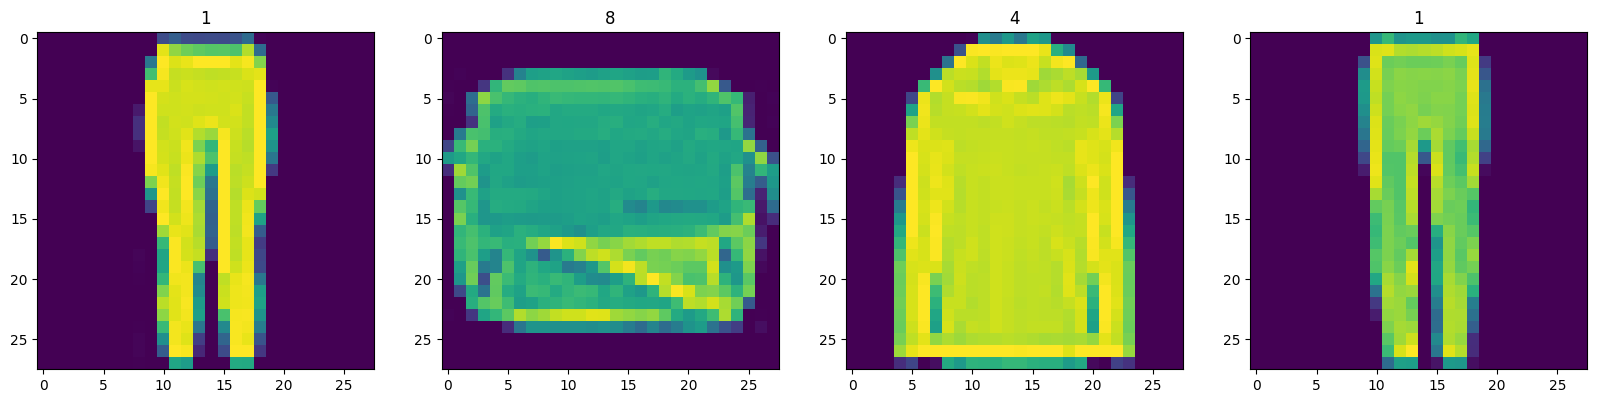

In [11]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx in range(4):
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title
    ax[idx].title.set_text(sample['label'])

In [13]:
# Scale and return images only
def scale_images(data):
    image = data['image']
    return image / 255

In [14]:
# Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up                                                   steps
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [15]:
ds.as_numpy_iterator().next().shape


(128, 28, 28, 1)

**3. Build Neural Network**

3.1 Import modelling components

In [17]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

3.2 Build generator

In [18]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model


In [19]:
generator = build_generator()

In [20]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [40]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


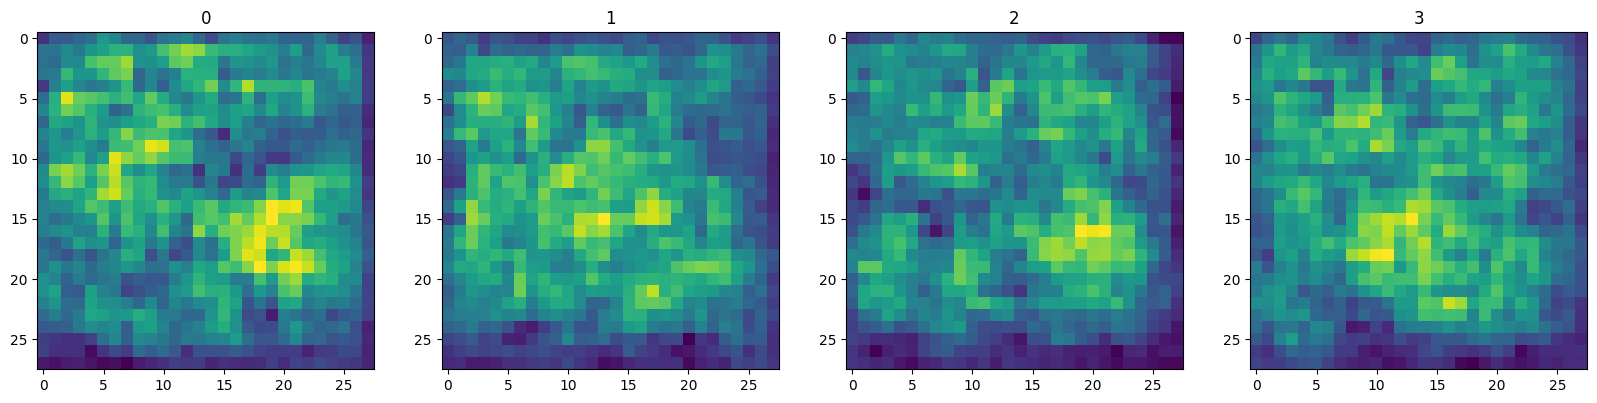

In [27]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

3.3 Build a discriminator

In [29]:
def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [30]:
discriminator = build_discriminator()

In [31]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [36]:
img = img[0]

In [41]:
img.shape

(4, 28, 28, 1)

In [42]:
discriminator.predict(img)        #not running for one image

1/1 [==============================] - 0s 251ms/step


array([[0.4979341 ],
       [0.49789223],
       [0.49781045],
       [0.49796176]], dtype=float32)

**4. Construct Training Loop**

4.1 Setup Losses and Optimizers

In [43]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [44]:

g_opt = Adam(learning_rate=0.0001)     #generator learning rate is higher
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

4.2 Build Subclassed Model

In [45]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [46]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [47]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [48]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

4.3 Build Callback

In [49]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [53]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('GANimages', f'generated_img_{epoch}_{i}.png'))

4.4 Train

In [52]:
!pwd

/content


In [54]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
  6/469 [..............................] - ETA: 1:15 - d_loss: 0.6936 - g_loss: 0.7306

469/469 [==============================] - 78s 167ms/step - d_loss: 0.6939 - g_loss: 0.7107
Epoch 2/20
469/469 [==============================] - 78s 166ms/step - d_loss: 0.5506 - g_loss: 1.2448
Epoch 3/20
469/469 [==============================] - 78s 166ms/step - d_loss: 0.2773 - g_loss: 2.6295
Epoch 4/20
469/469 [==============================] - 78s 167ms/step - d_loss: 0.2735 - g_loss: 2.7103
Epoch 5/20
469/469 [==============================] - 78s 167ms/step - d_loss: 0.2724 - g_loss: 2.7145
Epoch 6/20
469/469 [==============================] - 78s 167ms/step - d_loss: 0.2704 - g_loss: 2.7147
Epoch 7/20
469/469 [==============================] - 78s 166ms/step - d_loss: 0.2692 - g_loss: 2.7038
Epoch 8/20
469/469 [==============================] - 78s 166ms/step - d_loss: 0.2680 - g_loss: 2.7011
Epoch 9/20
469/469 [==============================] - 78s 166ms/step - d_loss: 0.2679 - g_loss: 2.7031
Epoch 10/20
469/469 [==============================] - 78s 166ms/step - d_loss: 0.26

4.4 Review Performance

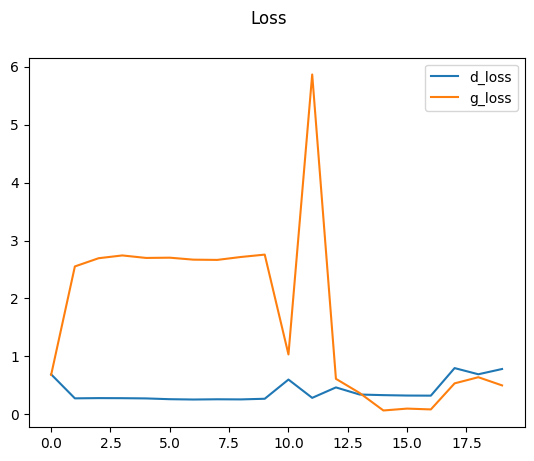

In [55]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

**5. Test Out the Generator**

In [58]:
generator.load_weights(os.path.join('/content/GANimages', 'generatormodel.h5'))


OSError: ignored

In [59]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))


1/1 [==============================] - 0s 322ms/step


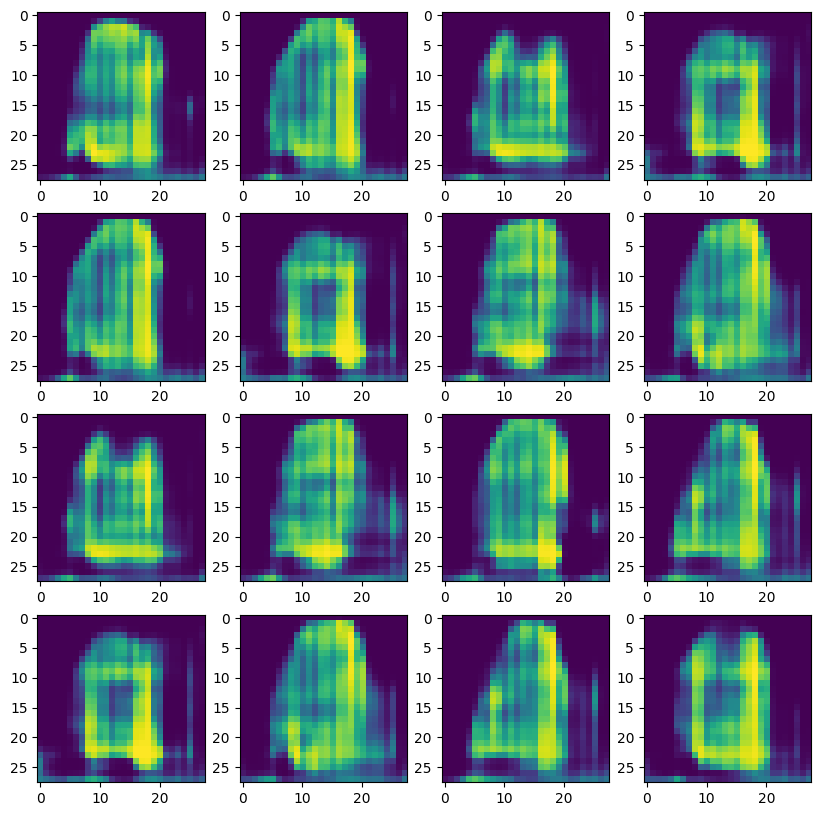

In [60]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

Save the model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')